In [1]:
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix, hstack
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn.ensemble import VotingClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("../data/cleanedData.csv")

In [3]:
#df['verfiable'] = df[['generalConsumer', 'govDomain', 'eduDomain', 'orgDomain', 'netDomain']].apply(lambda row: 1 if (row == 1).any() else 0, axis=1)
xText = df['fullContent']
xBinary = csr_matrix(df[['urls', 'generalConsumer', 'govDomain', 'eduDomain', 'orgDomain', 'netDomain', 'otherDomain', 'html']].values)
xCont = df[['punctuationCount', 'subjectLength', 'bodyLength', 'totalLength']]
y = df['label']

In [4]:
X_train_text, X_test_text, X_train_bin, X_test_bin, X_train_cont, X_test_cont, Y_train, Y_test = train_test_split(
    xText, xBinary, xCont, y, test_size = 0.2, random_state=1
)

In [5]:
tfidf = TfidfVectorizer()
X_train_text_tfidf = tfidf.fit_transform(X_train_text)
X_test_text_tfidf = tfidf.transform(X_test_text)

In [6]:
scaler = StandardScaler()
X_train_cont_scaled = scaler.fit_transform(X_train_cont)
X_test_cont_scaled = scaler.transform(X_test_cont)

In [7]:
baseM = MultinomialNB()
baseB = BernoulliNB()
baseG = GaussianNB()

In [8]:
baseM.fit(X_train_text_tfidf, Y_train)
baseB.fit(X_train_bin, Y_train)
baseG.fit(X_train_cont_scaled, Y_train)

GaussianNB()

In [9]:
preds_mnb = baseM.predict(X_test_text_tfidf)
preds_bnb = baseB.predict(X_test_bin)
preds_gnb = baseG.predict(X_test_cont_scaled)

baseAccM = accuracy_score(Y_test, preds_mnb)
baseAccB = accuracy_score(Y_test, preds_bnb)
baseAccG = accuracy_score(Y_test, preds_gnb)

baseProbaM = baseM.predict_proba(X_test_text_tfidf)
baseProbaB = baseB.predict_proba(X_test_bin)
baseProbaG = baseG.predict_proba(X_test_cont_scaled)

accList = [baseAccM,baseAccB,baseAccG]
probaList = [baseProbaM,baseProbaB,baseProbaG]

In [10]:
def calculateWeight(accList):
    total_accuracy = sum(accList)
    print(f"Multinomial Accuracy: {accList[0]*100:.2f}%")
    print(f"Bernoulli Accuracy: {accList[1]*100:.2f}%")
    print(f"Gaussian Accuracy: {accList[2]*100:.2f}%")
    print()
    weights = []
    # Normalize to get weights
    for i in accList:
        weights.append(i / total_accuracy)

    # Print the weights
    print(f'Weight for Multinomial: {weights[0]:.2f}')
    print(f'Weight for Bernoulli: {weights[1]:.2f}')
    print(f'Weight for Gaussian: {weights[2]:.2f}')
    return weights

def printEnsembleAccuracy(weights, probabilities, testLabel):
    # Combine probabilities with weights
    combined_proba = (weights[0] * probabilities[0] +
                    weights[1] * probabilities[1] +
                    weights[2] * probabilities[2])

    # Make final predictions
    y_pred_final = np.argmax(combined_proba, axis=1)
    # Evaluate accuracy
    # By matching final prediction to test label, the sum of correct prediction / number of prediction made
    accuracy = (y_pred_final == testLabel.values).mean()
    print(f'Naive Bayes Ensemble Accuracy: {accuracy*100:.2f}')
    return y_pred_final

def printCM(predictLabels, trueLabels):
    class_report = classification_report(trueLabels, predictLabels)
    print(class_report)

    cm = confusion_matrix(trueLabels, predictLabels)

    # Define class labels for the confusion matrix (for binary classification)
    class_labels = ['Phishing', 'Non-Phishing']  # Adjust according to your classes

    # Create the heatmap without annotations (annot=False)
    plt.figure(figsize=(8, 6))
    ax = sns.heatmap(cm, annot=False, fmt='d', cmap='Blues', cbar=False)

    # Set axis labels
    ax.set_xlabel('True', fontsize=12)
    ax.set_ylabel('Predicted', fontsize=12)

    # Set the class labels on the axes
    ax.set_xticklabels(class_labels, fontsize=10)
    ax.set_yticklabels(class_labels, fontsize=10)

    # Set title
    plt.title('Confusion Matrix')

    # Manually add True Positive, False Positive, True Negative, and False Negative annotations
    # You must use the exact cell positions for each term in the 2x2 confusion matrix
    ax.text(0.5, 0.5, 'TP\n(' + str(cm[1, 1]) + ')', ha='center', va='center', fontsize=12)
    ax.text(1.5, 0.5, 'FP\n(' + str(cm[0, 1]) + ')', ha='center', va='center', fontsize=12)
    ax.text(0.5, 1.5, 'FN\n(' + str(cm[1, 0]) + ')', ha='center', va='center', fontsize=12)
    ax.text(1.5, 1.5, 'TN\n(' + str(cm[0, 0]) + ')', ha='center', va='center', fontsize=12)

    # Show the plot
    plt.tight_layout()
    return plt.show()


In [11]:
weightPrediction = printEnsembleAccuracy(calculateWeight(accList), probaList, Y_test)

Multinomial Accuracy: 96.85%
Bernoulli Accuracy: 61.06%
Gaussian Accuracy: 63.58%

Weight for Multinomial: 0.44
Weight for Bernoulli: 0.28
Weight for Gaussian: 0.29
Naive Bayes Ensemble Accuracy: 97.41


              precision    recall  f1-score   support

           0       0.96      0.98      0.97      4210
           1       0.99      0.96      0.98      4648

    accuracy                           0.97      8858
   macro avg       0.97      0.97      0.97      8858
weighted avg       0.97      0.97      0.97      8858



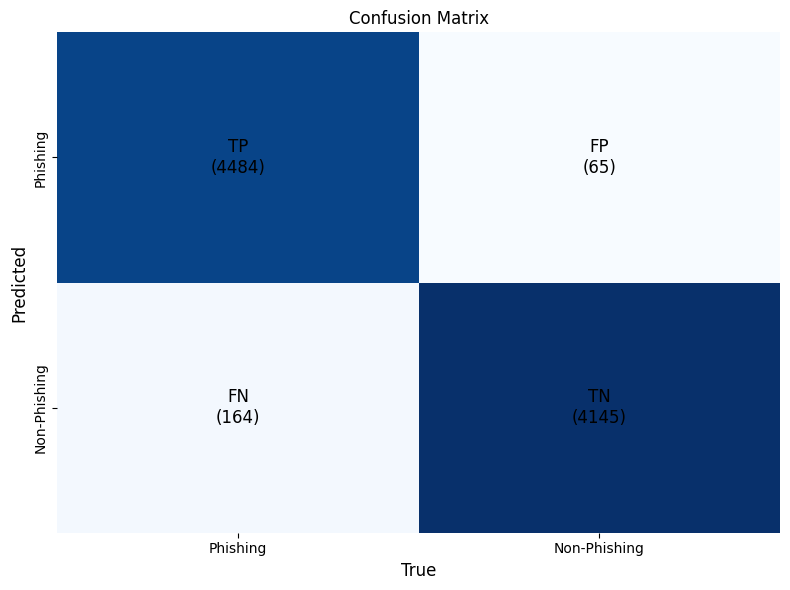

In [12]:
printCM(weightPrediction, Y_test)